# KDE demo, with histosys!

> It works :)

![](assets/kde_pyhf_animation.gif)

In [ ]:
import time

import jax
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.random
from jax.random import PRNGKey
import numpy as np
from functools import partial

import pyhf
pyhf.set_backend('jax')
pyhf.default_backend = pyhf.tensor.jax_backend(precision='64b')

from neos import data, makers
from relaxed import infer

rng = PRNGKey(22)

In [ ]:
# regression net
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

## Compose differentiable workflow

In [ ]:
dgen = data.generate_blobs(rng,blobs=4) 

# Specify our hyperparameters ahead of time for the kde histograms
bins = np.linspace(0,1,4)
bandwidth=0.27

hmaker = makers.hists_from_nn(dgen, predict, hpar_dict = dict(bins=bins,bandwidth=bandwidth),method='kde')
nnm = makers.histosys_model_from_hists(hmaker)
get_cls = infer.make_hypotest(nnm, solver_kwargs=dict(pdf_transform=True))

# loss returns a list of metrics -- let's just index into one (CLs)
def loss(params, test_mu):
    return get_cls(params, test_mu)["CLs"]

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [ ]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

# gradient wrt nn weights
jax.value_and_grad(loss)(network, test_mu=1.0)

(DeviceArray(0.05989214, dtype=float64),
 [(DeviceArray([[-2.6561795e-05, -1.3431838e-04,  3.7267394e-04, ...,
                 -9.5937648e-05, -3.1907926e-04, -4.7556667e-05],
                [ 3.2410408e-05,  1.6153457e-04, -2.3639399e-04, ...,
                 -7.6833285e-06,  3.2346524e-04,  2.8453616e-05]],            dtype=float32),
   DeviceArray([-1.0775060e-06,  1.6448357e-05,  2.5383127e-04, ...,
                 9.4325784e-05, -2.0307447e-04, -1.4521212e-05],            dtype=float32)),
  (),
  (DeviceArray([[ 2.0301204e-07, -2.2220854e-06,  6.1780784e-06, ...,
                 -1.0296096e-07,  6.6260043e-07,  4.6643160e-07],
                [ 4.1513945e-07,  9.9888112e-08,  1.8419865e-05, ...,
                  4.3947058e-08,  6.2674635e-06, -1.1988274e-06],
                [-2.0467697e-08, -1.2231366e-05,  5.6882186e-08, ...,
                 -6.0378164e-07, -1.1139725e-05,  3.0422871e-06],
                ...,
                [ 4.0854286e-07, -6.6176659e-07,  1.1947506e-0

### Define training loop!

In [ ]:
opt_init, opt_update, opt_params = optimizers.adam(1e-3)

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []

    # parameter update function
    # @jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net

    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i, state, 1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [ ]:
def plot(axarr, network, metrics, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = bins
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="binary",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    sig, bkg_nom, bkg_up, bkg_down = dgen()

    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.3, c="C9")
    ax.scatter(bkg_up[:, 0], bkg_up[:, 1], alpha=0.1, c="C1", marker=6)
    ax.scatter(bkg_down[:, 0], bkg_down[:, 1], alpha=0.1, c="C1", marker=7)
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.3, c="C1")

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.15)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$CL_s$")

    ax = axarr[2]
    s, b, bup, bdown = hmaker(network)

    bin_width = 1 / (len(bins) - 1)
    centers = bins[:-1] + np.diff(bins) / 2.0

    ax.bar(centers, b, color="C1", width=bin_width)
    ax.bar(centers, s, bottom=b, color="C9", width=bin_width)

    bunc = np.asarray([[x, y] if x > y else [y, x] for x, y in zip(bup, bdown)])
    plot_unc = []
    for unc, be in zip(bunc, b):
        if all(unc > be):
            plot_unc.append([max(unc), be])
        elif all(unc < be):
            plot_unc.append([be, min(unc)])
        else:
            plot_unc.append(unc)

    plot_unc = np.asarray(plot_unc)
    b_up, b_down = plot_unc[:, 0], plot_unc[:, 1]

    ax.bar(centers, b_up - b, bottom=b, alpha=0.4, color="black", width=bin_width)
    ax.bar(
        centers, b - b_down, bottom=b_down, alpha=0.4, color="black", width=bin_width
    )

    ax.set_ylim(0, 60)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

### Let's run it!!

epoch 0: CLs = 0.06000041396565026, took 1.6773879528045654s


ValueError: too many values to unpack (expected 2)

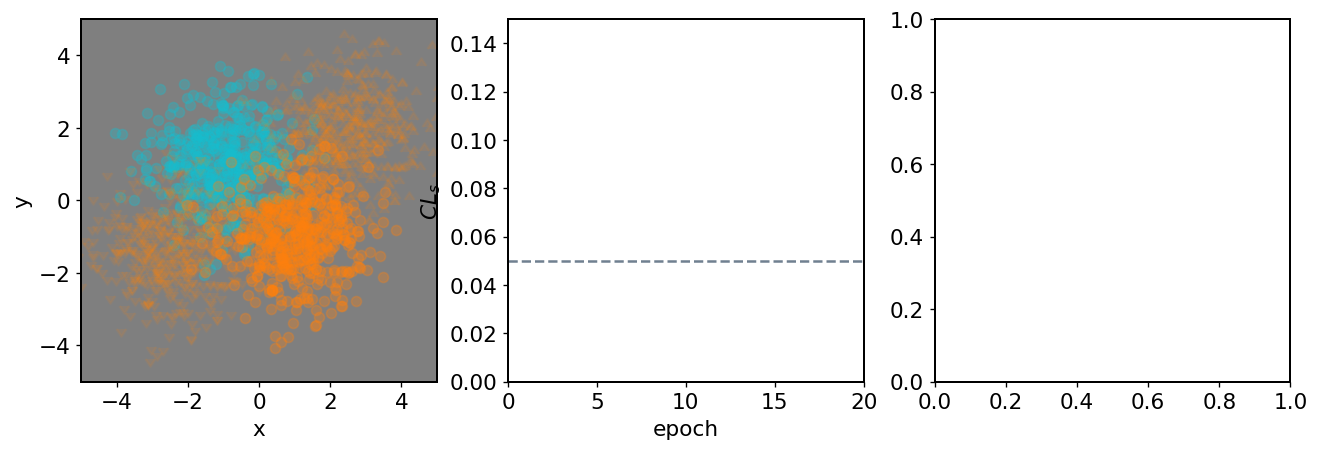

In [ ]:
# slow
import numpy as np
from IPython.display import HTML

from matplotlib import pyplot as plt

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [13.0, 4.0],
        "font.size": 13,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3, dpi=120)

maxN = 20  # make me bigger for better results!

animate = True  # animations fail tests...

if animate:
    from celluloid import Camera

    camera = Camera(fig)

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        if i % 10 == 0:
            camera.animate().save("animation.gif", writer="imagemagick", fps=8)
            # HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("animation.gif", writer="imagemagick", fps=8)